# <center>Классификация фильмов по жанрам
Данные взяты с [соревнования на *Kaggle*](https://www.kaggle.com/competitions/sf-dl-movie-genre-classification/overview)

Описание столбцов в датасете:

* `name` - название фильма
* `text` - описание фильма

Целевой признак:

* `genre` - жанр фильма

<a id='start'></a>

## <center>Знакомство с данными

In [22]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio

from wordcloud import WordCloud

import nltk

import optuna

from IPython.display import Markdown

from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from sklearn.base import TransformerMixin, BaseEstimator

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
RANDOM_STATE = 42
N_JOBS = -1

In [23]:
data = pd.read_csv('../data/train.csv.zip')
display(
    Markdown('### Пример данных'),
    data.sample(3, random_state=RANDOM_STATE),
    Markdown(f'### Количество пропусков: {data.isna().sum().sum()}'),
    Markdown(f'### Количество дубликатов: {data.duplicated().sum()}'),
    Markdown('### Характеристики признаков'),
    data.describe().T
)

### Пример данных

,name,genre,text
5089,Sisterhood (2008),comedy,"Catherine St.John-Burke is an independent, up..."
30323,Idylle (1983),short,"Beginning of the century. In a train, a young..."
6415,The Lost Skeleton Returns Again (2009),comedy,"Jerranium 90, a ""little rock"" that made all t..."


### Количество пропусков: 0

### Количество дубликатов: 0

### Характеристики признаков

,count,unique,top,freq
name,54214,54214,Oscar et la dame rose (2009),1
genre,54214,27,drama,13613
text,54214,54086,Grammy - music award of the American academy ...,12


Напишем отдельный трансформер, чтобы удалить признак `name` и создать признак `year` - год выпуска фильма. Пропуски заполним медианой

In [24]:
class YearTransormer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        
    def fit(self, X:pd.DataFrame, y=None):
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy['year'] = X_copy['name'].str.findall(r'\((.*)\)').apply(lambda year: year[0] if year[0].isnumeric() else None)
        X_copy['year'] = X_copy['year'].fillna(X_copy['year'].median()).astype(int)
        X_copy.drop(columns='name', inplace=True)
        return X_copy

Применим трансформер к данным и выведем результат

In [25]:
year_transformer = YearTransormer()
data = year_transformer.fit_transform(data)
data.sample(3, random_state=RANDOM_STATE)

,genre,text,year
5089,comedy,"Catherine St.John-Burke is an independent, up...",2008
30323,short,"Beginning of the century. In a train, a young...",1983
6415,comedy,"Jerranium 90, a ""little rock"" that made all t...",2009


## <center>Визуальный анализ данных
### Распределение целевого признака

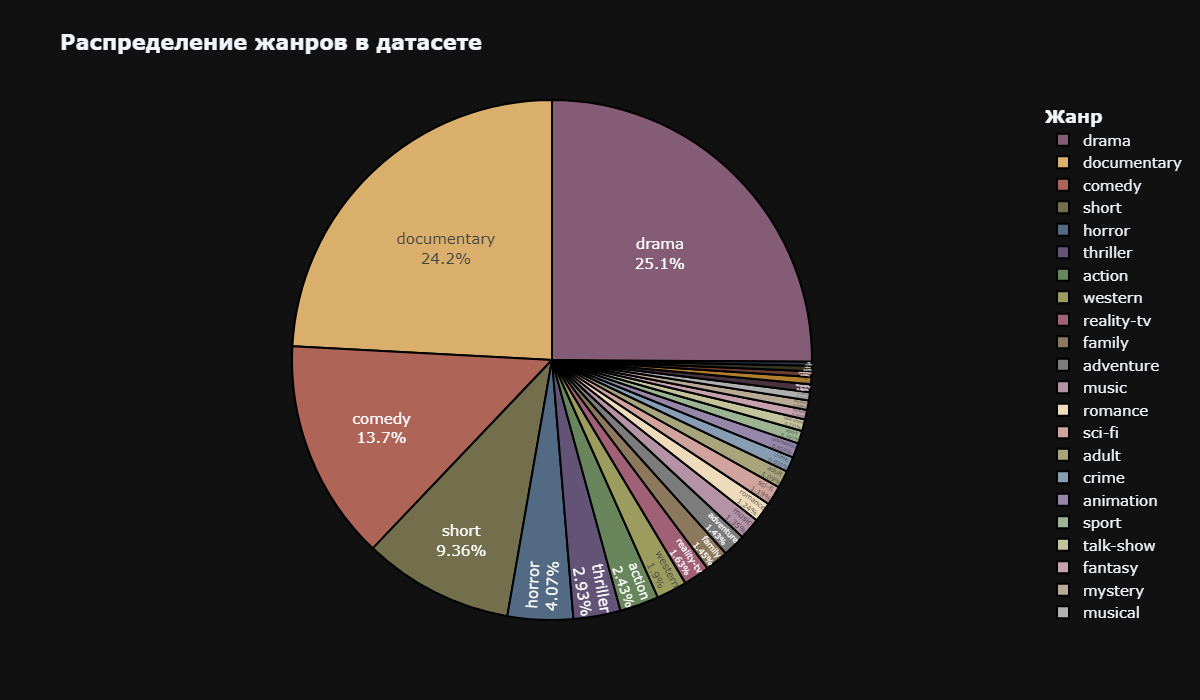

In [26]:
px.pie(
    data_frame=data,
    names='genre',
    height=700,
    width=1200,
    color_discrete_sequence=px.colors.qualitative.Antique,
    title='<b>Распределение жанров в датасете</b>'
).update_traces(
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=2)), 
    textposition='inside'
).update_layout(legend_title='<b>Жанр</b>', font=dict(size=15))

Для удобства визуализируем топ-10 наиболее часто встречающихся жанров

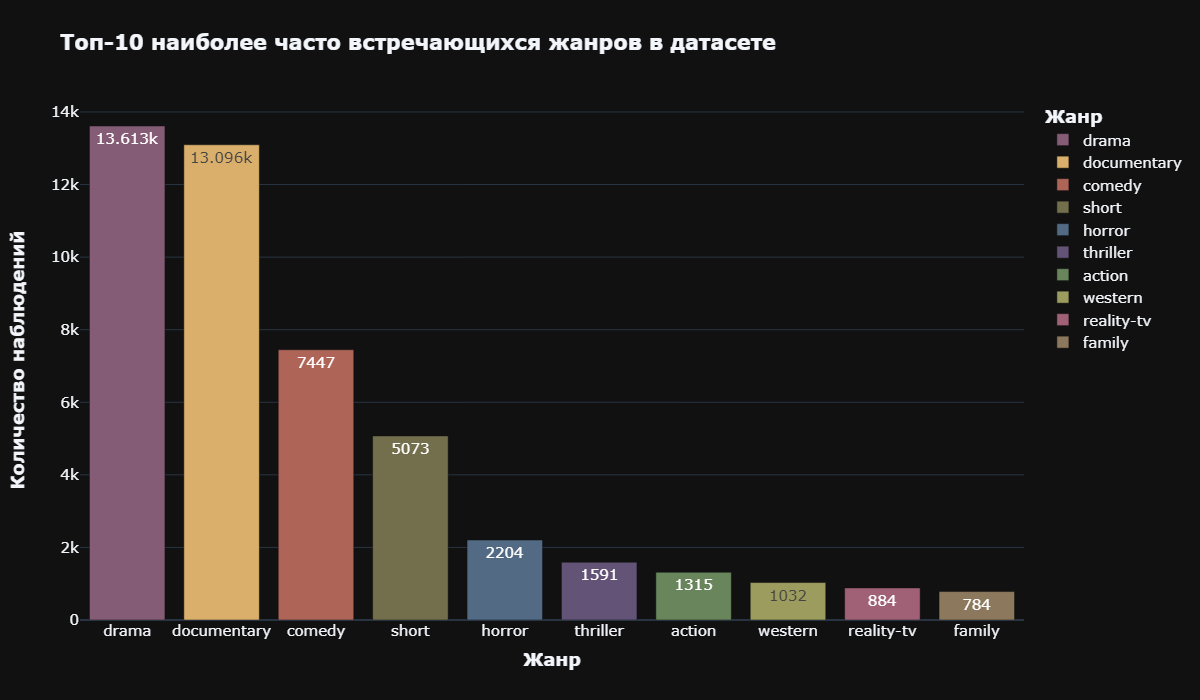

In [41]:
grouped_genre = data.groupby('genre', as_index=False)['year'].count().sort_values(by='year', ascending=False).head(10)

px.bar(
    data_frame=grouped_genre,
    x='genre',
    y='year',
    color='genre',
    title='<b>Топ-10 наиболее часто встречающихся жанров в датасете</b>',
    color_discrete_sequence=px.colors.qualitative.Antique,
    text_auto=True,
    width=1200,
    height=700,
    labels={
        'genre': '<b>Жанр</b>',
        'year': '<b>Количество наблюдений</b>'
    }
).update_layout(font=dict(size=15))

### Распределение признака `year`

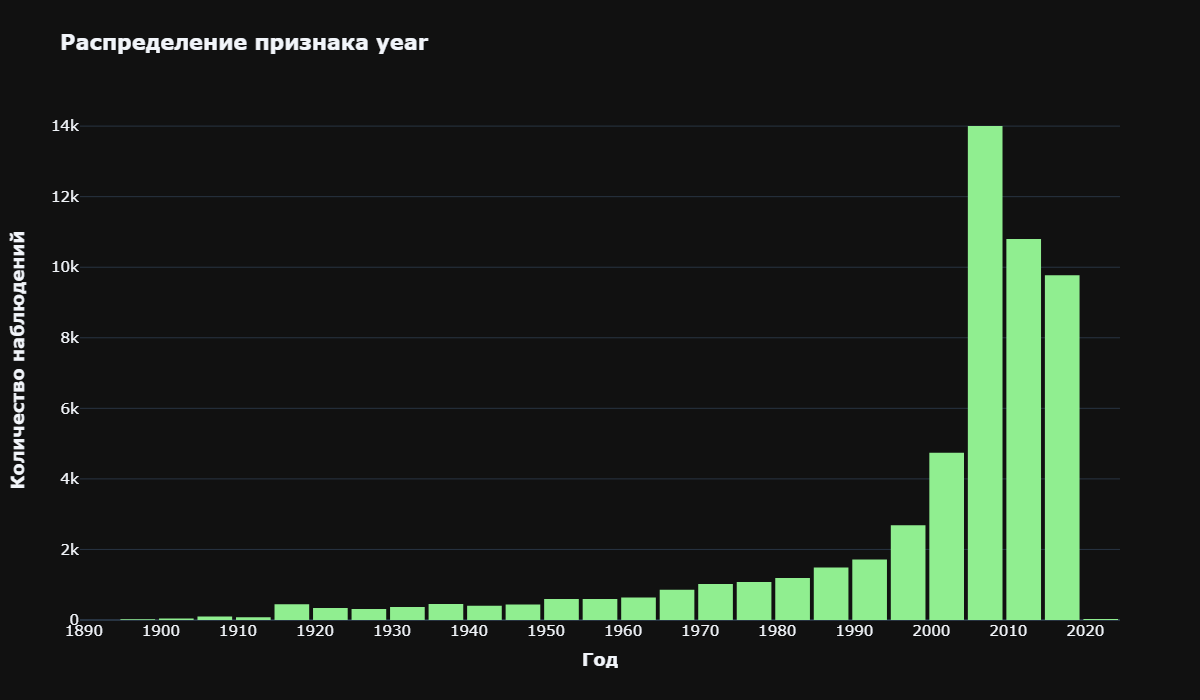

In [74]:
px.histogram(
    data_frame=data,
    x='year',
    width=1200,
    height=700,
    nbins=50,
    color_discrete_sequence=['#90EE90'],
    title='<b>Распределение признака year</b>',
    labels=dict(year='<b>Год</b>')
).update_xaxes(
    tickformat='linear',
    dtick=10
).update_layout(
    bargap=0.1, 
    font=dict(size=15),
).update_yaxes(title='<b>Количество наблюдений</b>')

### *Wordcloud* для каждого жанра